In [23]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.datasets import fetch_openml
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score
from statsmodels.api import OLS, add_constant
from sklearn.cluster import KMeans
housing = fetch_openml(name="house_prices", as_frame=True)
df = housing.frame.copy()

In [24]:
# (1) How many columns are in the housing dataset? How many rows?
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   Id             1460 non-null   int64  
 1   MSSubClass     1460 non-null   int64  
 2   MSZoning       1460 non-null   object 
 3   LotFrontage    1201 non-null   float64
 4   LotArea        1460 non-null   int64  
 5   Street         1460 non-null   object 
 6   Alley          91 non-null     object 
 7   LotShape       1460 non-null   object 
 8   LandContour    1460 non-null   object 
 9   Utilities      1460 non-null   object 
 10  LotConfig      1460 non-null   object 
 11  LandSlope      1460 non-null   object 
 12  Neighborhood   1460 non-null   object 
 13  Condition1     1460 non-null   object 
 14  Condition2     1460 non-null   object 
 15  BldgType       1460 non-null   object 
 16  HouseStyle     1460 non-null   object 
 17  OverallQual    1460 non-null   int64  
 18  OverallC

In [25]:
# (2) List 5 numerical features and 3 categorical variables.
numerical_features = df.select_dtypes(include=[np.number]).columns.tolist()
categorical_features = df.select_dtypes(include=['object']).columns.tolist()
print("Numerical Features:", numerical_features)
print("Categorical Features:", categorical_features)

Numerical Features: ['Id', 'MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']
Categorical Features: ['MSZoning', 'Street', 'Alley', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'Firepla

In [26]:
# (3) Fill missing values in LotFrontage with the median. What assumption are you making on the missing data by doing this?
df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace=True)

C:\Users\rka304\AppData\Local\Temp\ipykernel_24896\853952213.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['LotFrontage'].fillna(df['LotFrontage'].median(), inplace=True)


In [27]:
# (4) How many unique neighborhoods are there?
unique_neighborhoods = df['Neighborhood'].nunique()
print("Unique Neighborhoods:", unique_neighborhoods)

Unique Neighborhoods: 25


In [28]:
# (5) Convert‘Neighborhood’ into numeric.
le = LabelEncoder()
df['Neighborhood'] = le.fit_transform(df['Neighborhood'])
print(df['Neighborhood'].head())

0     5
1    24
2     5
3     6
4    15
Name: Neighborhood, dtype: int64


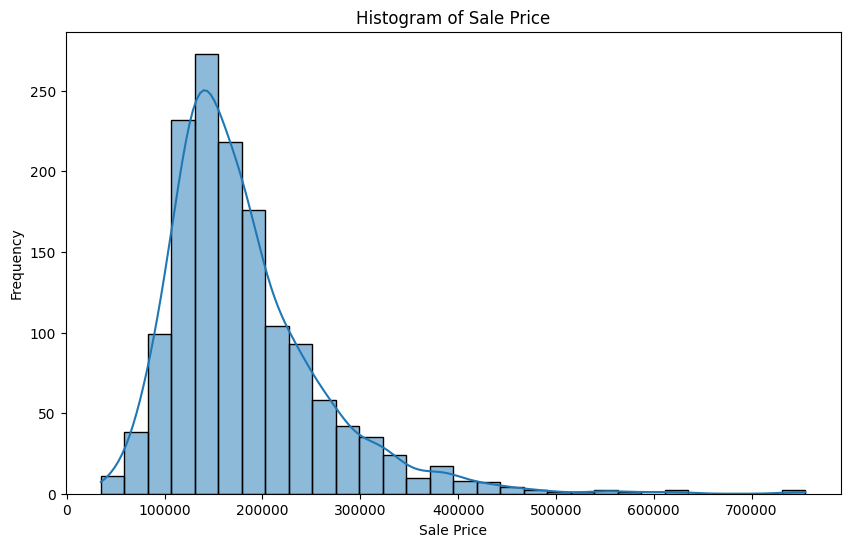

In [ ]:
# (6) Create a histogram of sales price. Comment on the shape of the distribution. Are there any outliers? What is another plot that would be helpful here?
plt.figure(figsize=(10, 6))
sns.histplot(df['SalePrice'], bins=30, kde=True)
plt.title('Histogram of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

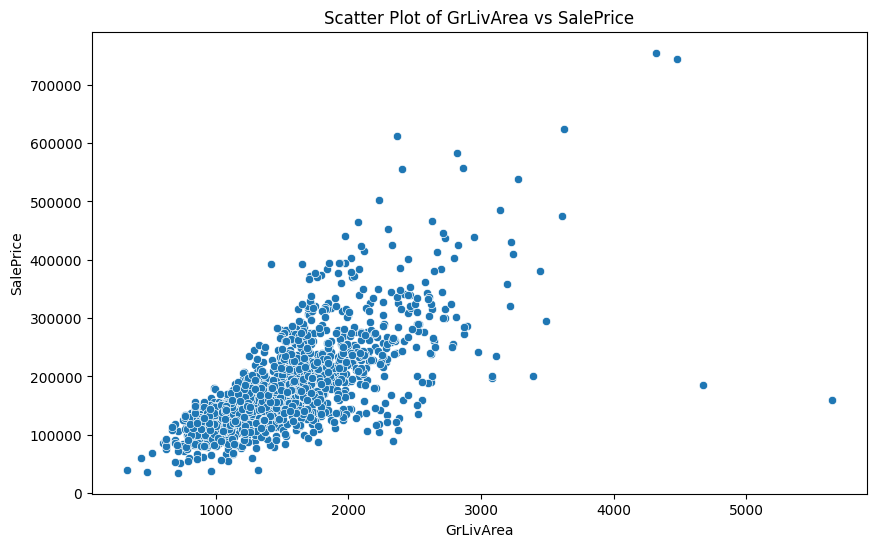

In [ ]:
# (7) Make a scatter plot of GrLivArea vs SalePrice. What kind of relationship do you observe (linear, nonlinear, none)?
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='SalePrice', data=df)
plt.title('Scatter Plot of GrLivArea vs SalePrice')
plt.xlabel('GrLivArea')
plt.ylabel('SalePrice')
plt.show()

In [32]:
# (8) Compute the correlation matrix for the numeric columns. Which three features are most strongly correlated with SalePrice?
# Select only numeric columns
numeric_df = df.select_dtypes(include=[np.number])
correlation_matrix = numeric_df.corr()
correlation_with_saleprice = correlation_matrix['SalePrice'].sort_values(ascending=False)
print("Top 3 features most strongly correlated with SalePrice:")
print(correlation_with_saleprice[1:4])

Top 3 features most strongly correlated with SalePrice:
OverallQual    0.790982
GrLivArea      0.708624
GarageCars     0.640409
Name: SalePrice, dtype: float64


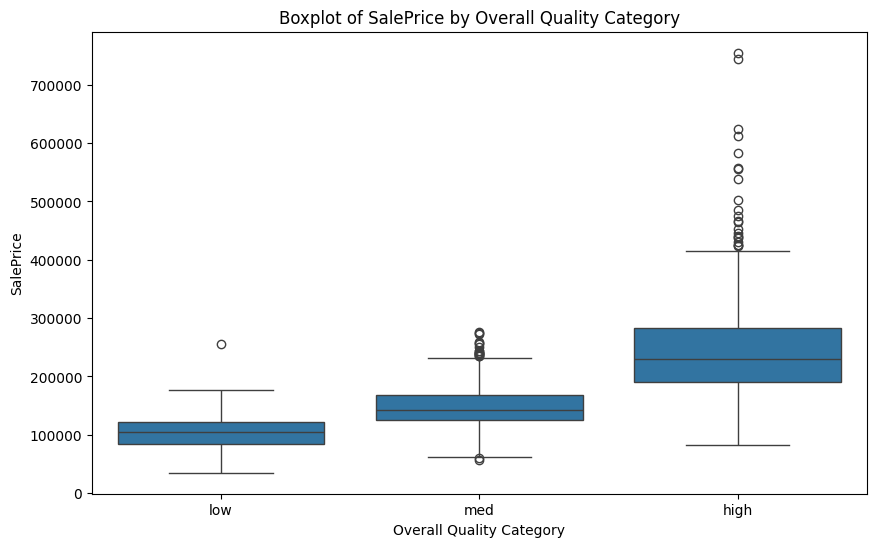

In [33]:
# (9) Create a new variable where you split OverallQual into low, med, high. Create a set of boxplots of SalePrice by your new variable. What does this show about how quality relates to price?
df['OverallQual_cat'] = pd.cut(df['OverallQual'], bins=[0, 4, 6, 10], labels=['low', 'med', 'high'])
plt.figure(figsize=(10, 6))
sns.boxplot(x='OverallQual_cat', y='SalePrice', data=df)
plt.title('Boxplot of SalePrice by Overall Quality Category')
plt.xlabel('Overall Quality Category')
plt.ylabel('SalePrice')
plt.show()

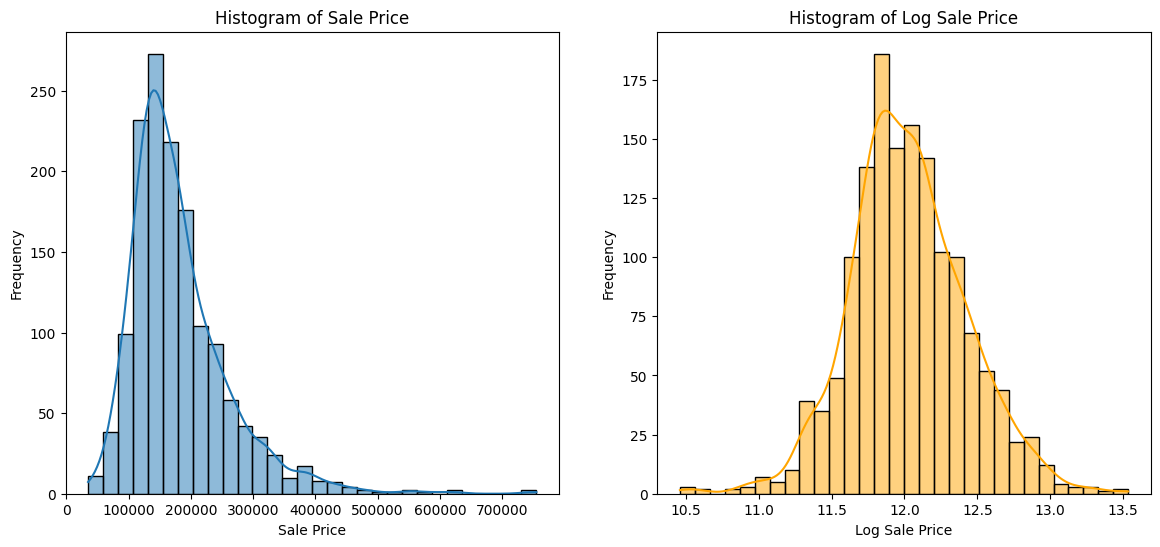

In [ ]:
# (10) The distribution of SalePrice is right-skewed, compute the log of sales price. Plot a histogram of both and explain the difference between the two figures.
df['LogSalePrice'] = np.log(df['SalePrice'])
plt.figure(figsize=(14, 6))
plt.subplot(1, 2, 1)
sns.histplot(df['SalePrice'], bins=30, kde=True)
plt.title('Histogram of Sale Price')
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.subplot(1, 2, 2)
sns.histplot(df['LogSalePrice'], bins=30, kde=True, color='orange')
plt.title('Histogram of Log Sale Price')
plt.xlabel('Log Sale Price')
plt.ylabel('Frequency')
plt.show()

In [35]:
# (11) Normalize or scale this subset of columns LotArea, GrLivArea, TotalBsmtSF
scaler = StandardScaler()
df[['LotArea', 'GrLivArea', 'TotalBsmtSF']] = scaler.fit_transform(df[['LotArea', 'GrLivArea', 'TotalBsmtSF']])
print(df[['LotArea', 'GrLivArea', 'TotalBsmtSF']].head())

    LotArea  GrLivArea  TotalBsmtSF
0 -0.207142   0.370333    -0.459303
1 -0.091886  -0.482512     0.466465
2  0.073480   0.515013    -0.313369
3 -0.096897   0.383659    -0.687324
4  0.375148   1.299326     0.199680


In [37]:
# (12) Split your data into training and testing sets (80/20). Fit a simple linear regression model predicting log_price using only GrLivArea. Report the estimated slope and intercept.
X = df[['GrLivArea']]
y = df['LogSalePrice']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
model = LinearRegression()
model.fit(X_train, y_train)
model.summary = OLS(y_train, add_constant(X_train)).fit()
print(model.summary.summary())


                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.475
Model:                            OLS   Adj. R-squared:                  0.474
Method:                 Least Squares   F-statistic:                     1054.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):          3.23e-165
Time:                        07:06:10   Log-Likelihood:                -182.83
No. Observations:                1168   AIC:                             369.7
Df Residuals:                    1166   BIC:                             379.8
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const         12.0245      0.008   1450.642      0.0

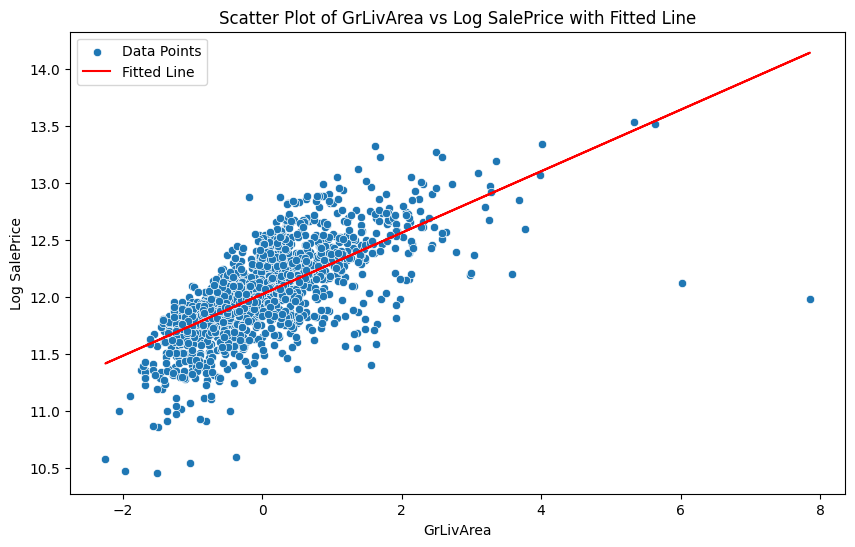

In [ ]:
# (13) Plot the fitted regression line on top of the scatter plot of GrLivArea vs log_price. Interpret the slope in plain English.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='LogSalePrice', data=df, label='Data Points')
plt.plot(X_train, model.predict(X_train), color='red', label='Fitted Line')
plt.title('Scatter Plot of GrLivArea vs Log SalePrice with Fitted Line')
plt.xlabel('GrLivArea')
plt.ylabel('Log SalePrice')
plt.legend()
plt.show()

In [40]:
# (14) Compute and report the R² value and RMSE on both train and test data. What do these metrics tell you about model fit?

# Make predictions on train and test data
y_train_pred = model.predict(X_train)
y_test_pred = model.predict(X_test)

# Calculate R² scores
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)

# Calculate RMSE
train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

# Report results
print("Model Performance Metrics:")
print(f"Training R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print(f"Training RMSE: {train_rmse:.4f}")
print(f"Test RMSE: {test_rmse:.4f}")

Model Performance Metrics:
Training R²: 0.4747
Test R²: 0.5402
Training RMSE: 0.2830
Test RMSE: 0.2929


In [41]:
# (15) Extend the regression model to include multiple predictors: # GrLivArea, OverallQual, and TotalBsmtSF. Compare the R² of this model to the simple one. Did model performance improve? Explain why or why not.
X_multi = df[['GrLivArea', 'OverallQual', 'TotalBsmtSF']]
X_train_multi, X_test_multi, y_train_multi, y_test_multi = train_test_split(X_multi, y, test_size=0.2, random_state=42)
model_multi = LinearRegression()
model_multi.fit(X_train_multi, y_train_multi)
model_multi.summary = OLS(y_train_multi, add_constant(X_train_multi)).fit()
print(model_multi.summary.summary())

                            OLS Regression Results                            
Dep. Variable:           LogSalePrice   R-squared:                       0.747
Model:                            OLS   Adj. R-squared:                  0.746
Method:                 Least Squares   F-statistic:                     1145.
Date:                Mon, 13 Oct 2025   Prob (F-statistic):               0.00
Time:                        07:36:25   Log-Likelihood:                 243.59
No. Observations:                1168   AIC:                            -479.2
Df Residuals:                    1164   BIC:                            -458.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          11.0768      0.034    321.277      

In [42]:
# (16) Test the null hypothesis that the coefficient on GrLivArea equals zero (no effect on price). Report the p-value and interpret it in the  context of the data. What does it mean if p < 0.05?
p_value = model_multi.summary.pvalues['GrLivArea']
print(f"P-value for GrLivArea coefficient: {p_value:.4f}")

P-value for GrLivArea coefficient: 0.0000


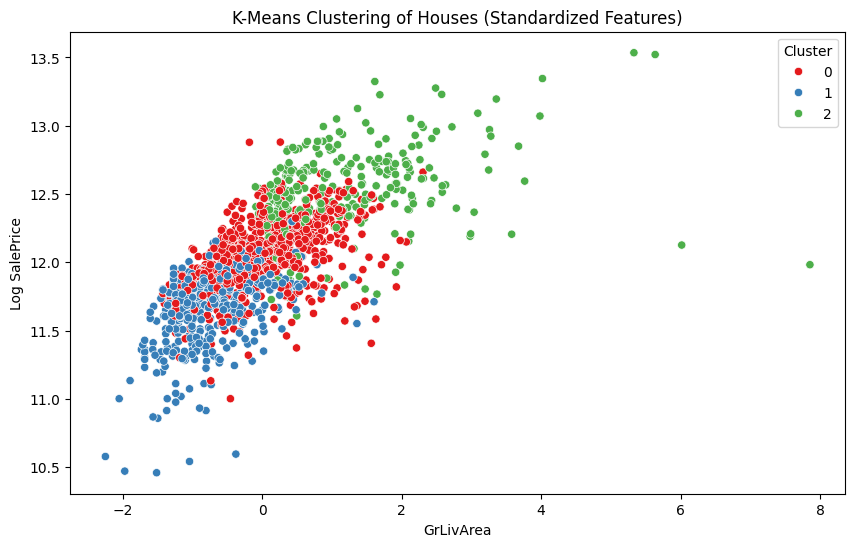

In [44]:
# (17)(18) Perform K-Means clustering on the standardized features: GrLivArea, TotalBsmtSF, and GarageArea.
# First, standardize GarageArea or standardize all three features together
scaler_cluster = StandardScaler()
features_to_cluster = ['GrLivArea', 'TotalBsmtSF', 'GarageArea']
df_cluster_scaled = scaler_cluster.fit_transform(df[features_to_cluster])

kmeans = KMeans(n_clusters=3, random_state=42)
df['Cluster'] = kmeans.fit_predict(df_cluster_scaled)

plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='LogSalePrice', hue='Cluster', data=df, palette='Set1')
plt.title('K-Means Clustering of Houses (Standardized Features)')
plt.xlabel('GrLivArea')
plt.ylabel('Log SalePrice')
plt.show()

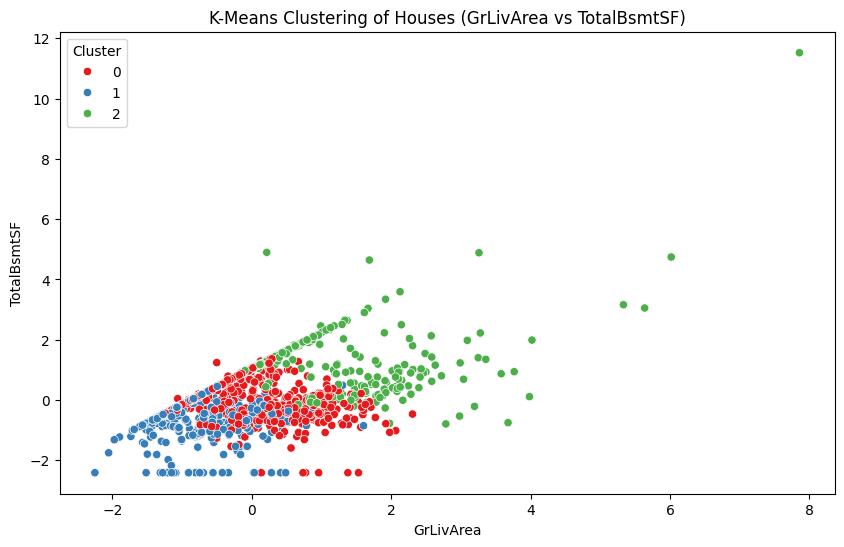

In [45]:
# (19) Use 3 clusters. Visualize the clusters with a scatter plot of GrLivArea vs TotalBsmtSF, coloring by cluster label.
plt.figure(figsize=(10, 6))
sns.scatterplot(x='GrLivArea', y='TotalBsmtSF', hue='Cluster', data=df, palette='Set1')
plt.title('K-Means Clustering of Houses (GrLivArea vs TotalBsmtSF)')
plt.xlabel('GrLivArea')
plt.ylabel('TotalBsmtSF')
plt.show()

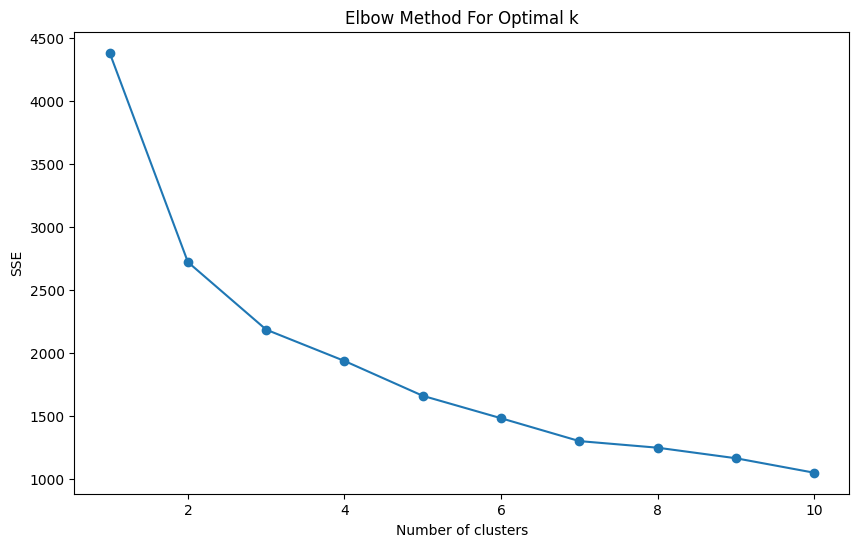

In [ ]:
# (20) Calculate the SSE and use the elbow method to calculate the optimal number of clusters. How many clusters is it? Do they visually look different?
sse = []
k_range = range(1, 11)
for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(df_cluster_scaled)
    sse.append(kmeans.inertia_)

plt.figure(figsize=(10, 6))
plt.plot(k_range, sse, marker='o')
plt.title('Elbow Method For Optimal k')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()
# The elbow point can be visually inspected from the plot.